# Kurtosis Experiments

For our kurtosis experiments, we will test the following integrand: $f(X) = \frac{Xe^X}{e}$ where $X \sim \text{U}(0, 1)$
 and uses RQMC with $R$ independent replications and $n$ QMC points per replication. We will use the following RQMC Methods: LMS_DS for Sobol and Halton, NUS for Sobol and Halton, and random shift for Lattice. The $n$ will be varied from {1,2,4,8,16,32,64} while $R$ will be kept constant at 1000. The goal is to see how the kurtosis changes as $n$ changes for the different RQMC methods listed above.

In [2]:
import qmcpy as qp
from scipy.stats import kurtosis
import numpy as np
import matplotlib.pyplot as plt

Setting up the parameters to be used:

In [3]:
qmc_generators = {
    "Sobol": ["LMS_DS", "NUS"],
    "Halton": ["LMS_DS", "NUS"],
    "Lattice": ["Shift"]
} # The different QMC generators with different randomizations
num_randomizations = sum(len(rands) for rands in qmc_generators.values())
labels = []
for gen, rands in qmc_generators.items():
    for rand in rands:
        labels.append(f"{gen}_{rand}")
labels = np.array(labels)

R = 1000 # The number of independent replications
n = 2**np.arange(0,7) # The different number of QMC points per replication

f = lambda x: x[...,0]*np.exp(x[...,0])/np.exp(1) # The integand to be tested

# seed setting

global_seed = 7
parent_seed = np.random.SeedSequence(global_seed)

The function to give the integrand evaluations of the RQMC pointset

In [4]:
def gen_output(discrete_distrib, function, n = 2**8):
    assert isinstance(discrete_distrib,(qp.DigitalNetB2,qp.Lattice,qp.Halton,qp.IIDStdUniform))
    x_rld = discrete_distrib.gen_samples(n).reshape((discrete_distrib.replications,n,discrete_distrib.d))
    y_rld = function(x_rld)
    return y_rld.mean(1)

### The Experiments/Simulations

In [5]:
arr = np.empty((num_randomizations,len(n),R))
row = 0
for gen, rands in qmc_generators.items():
    for rand in rands:
        for curr_n in range (len(n)):
            child_seed = parent_seed.spawn(1)[0]
            if gen.lower() == "sobol":
                distrib = qp.Sobol(dimension = 1, randomize = rand, seed = child_seed, replications = R)
            elif gen.lower() == 'halton':
                distrib = qp.Halton(dimension = 1, randomize = rand, seed = child_seed, replications = R)
            else:
                distrib = qp.Lattice(dimension = 1, randomize = rand, seed = child_seed, replications = R)
            arr[row,curr_n,:] = gen_output(distrib,f,n = n[curr_n])
        row = row + 1


### The Histograms

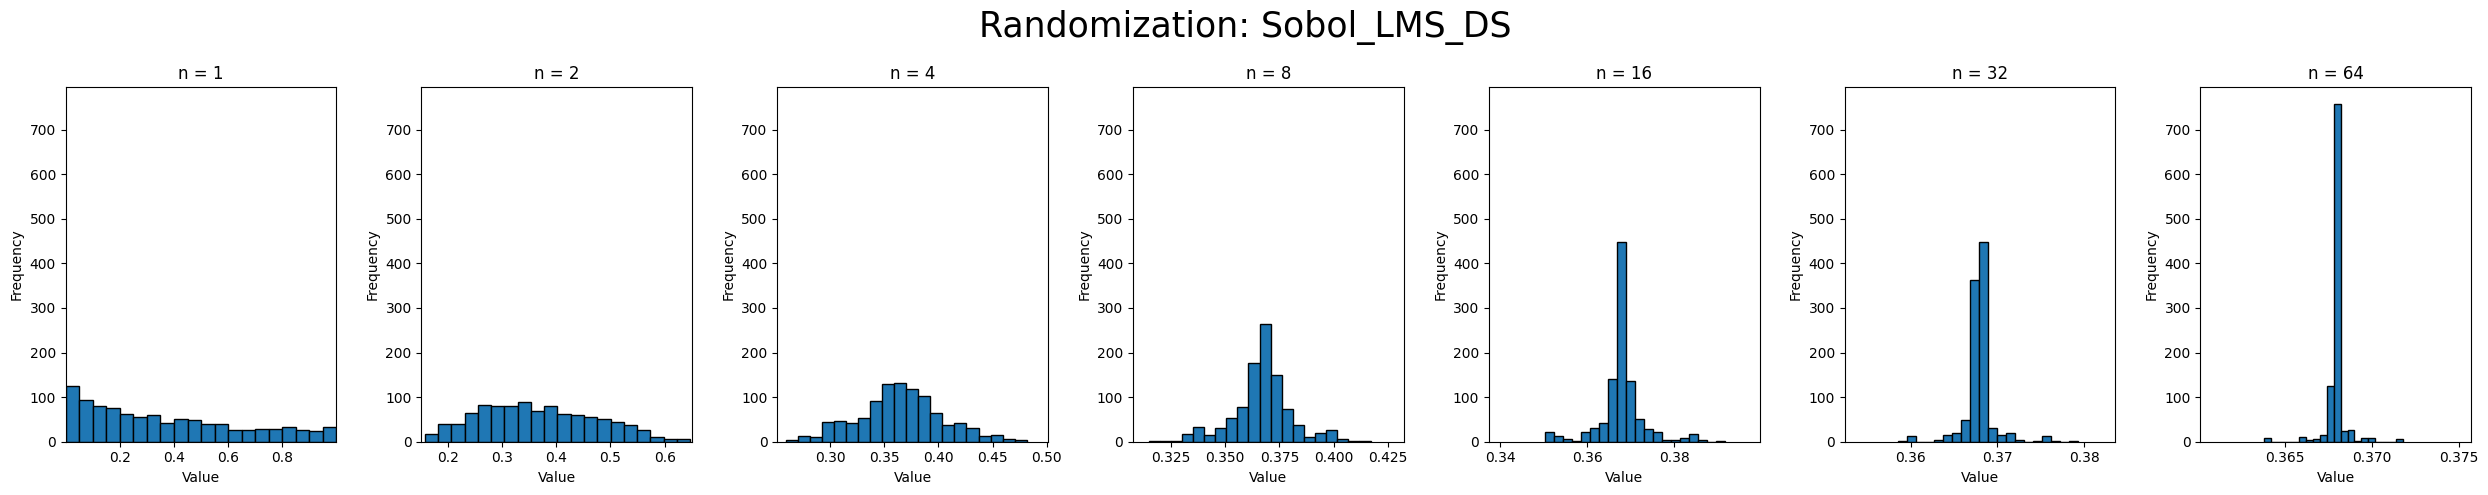

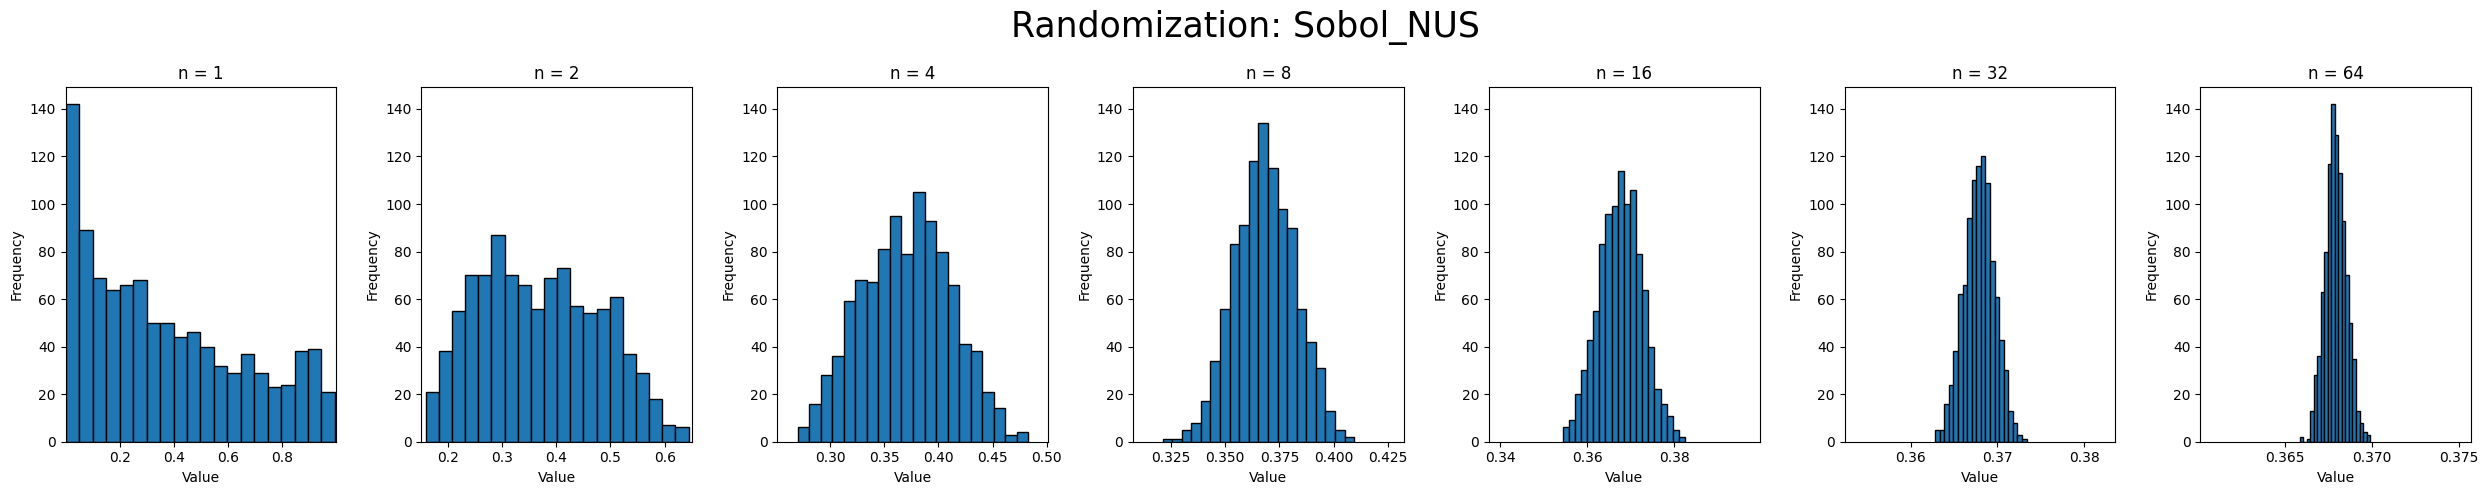

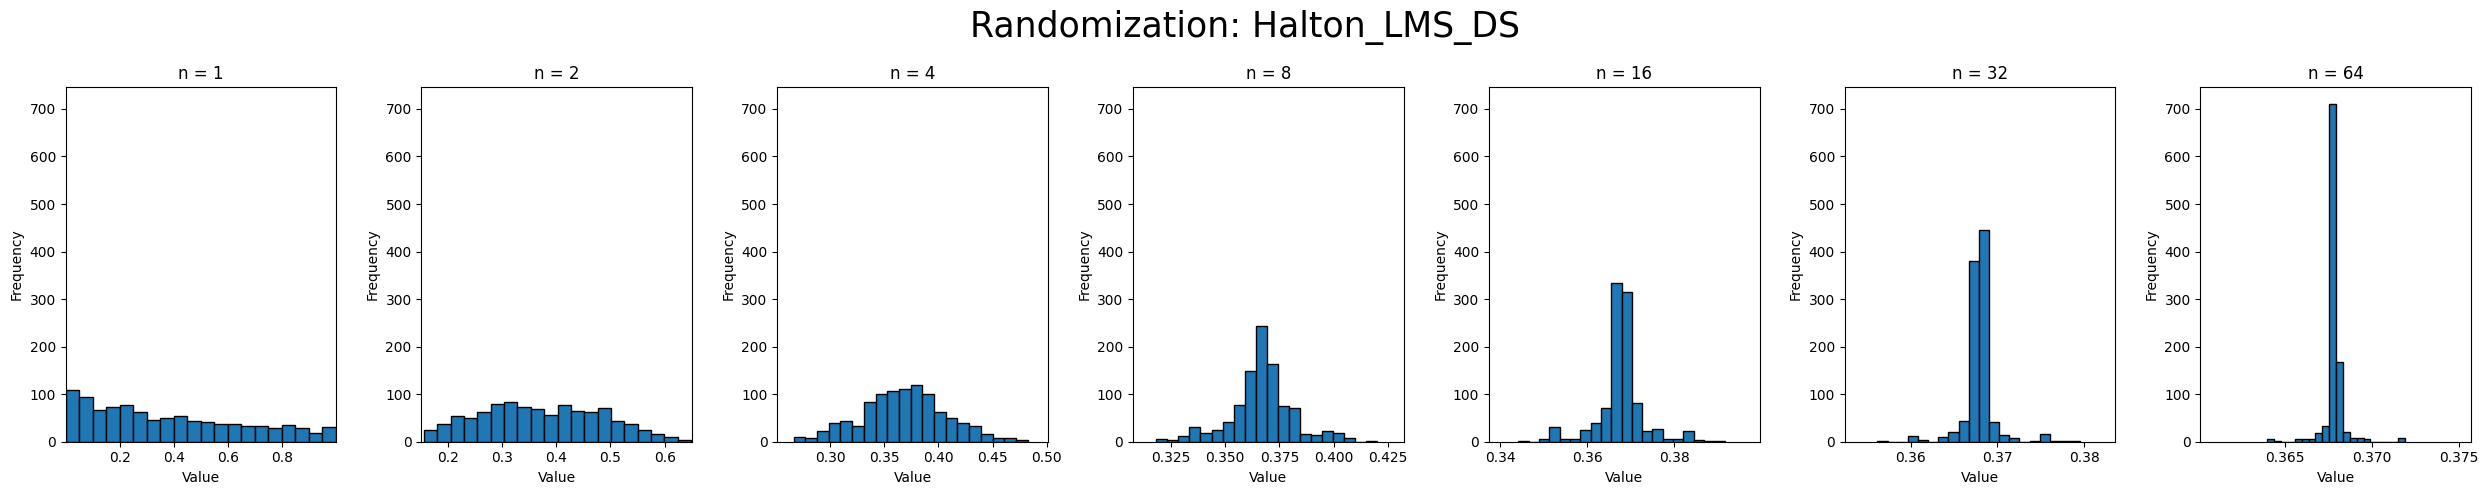

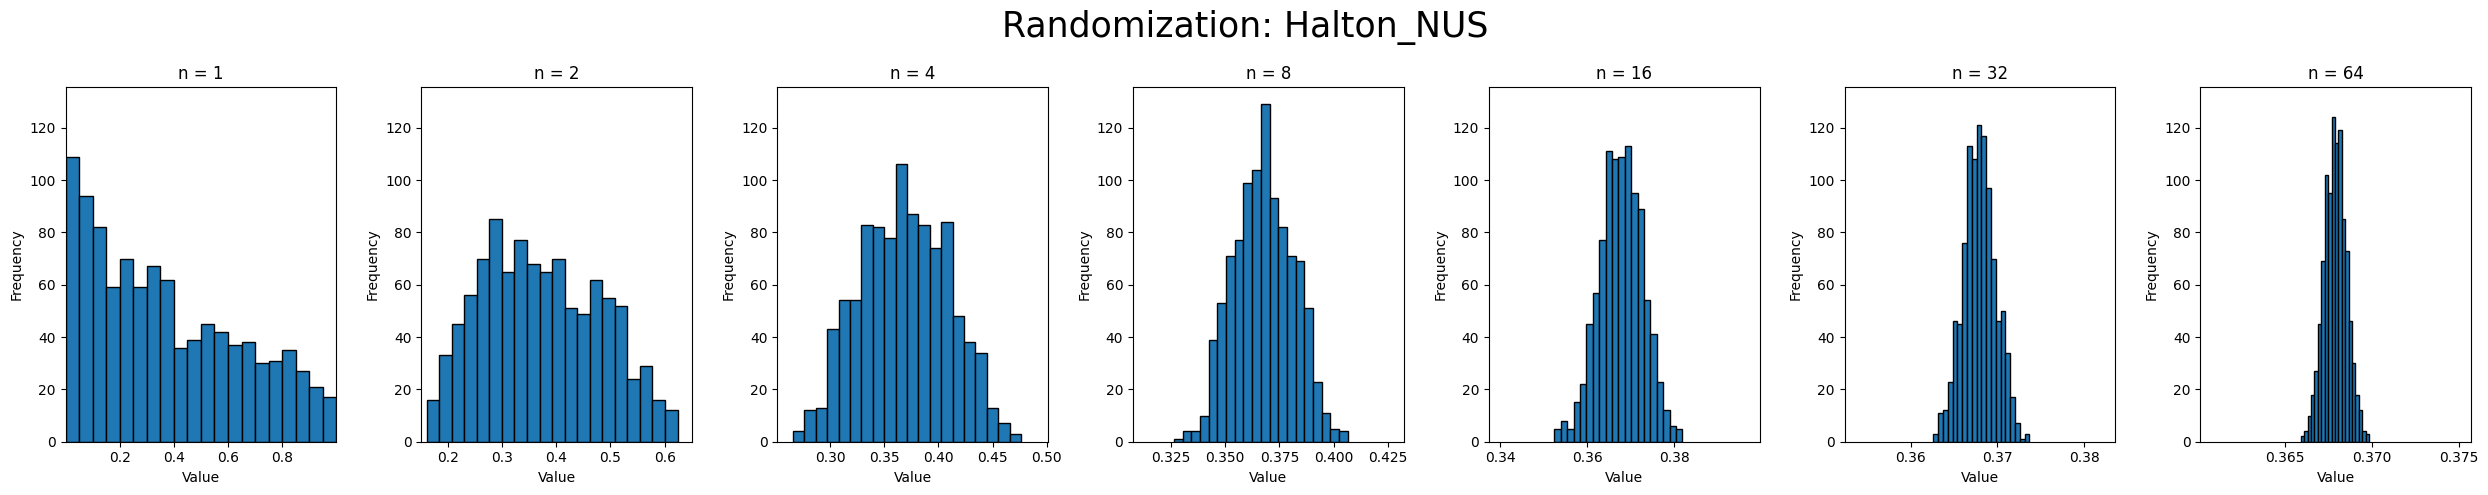

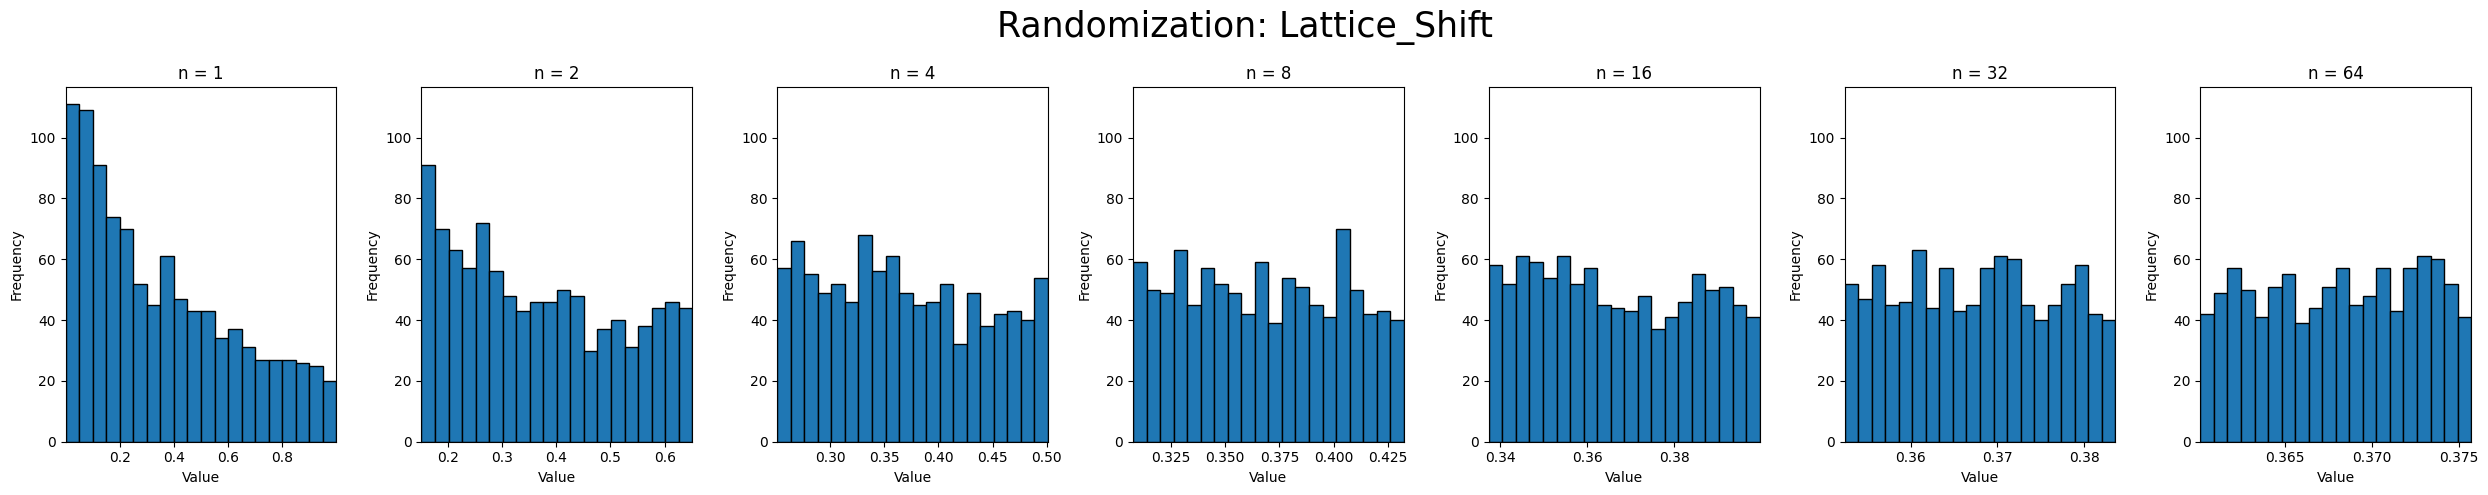

In [10]:
x_lims = []
for j in range(len(n)):
    all_data_j = arr[:, j, :].flatten()
    x_min, x_max = all_data_j.min(), all_data_j.max()
    x_lims.append((x_min, x_max))

for i in range(num_randomizations):
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=len(n), 
        figsize=(25,5)
    )
    
    if len(n) == 1:
        axes = [axes]
    
    max_ylim = 0  # Track max y limit for this figure

    for j in range(len(n)):
        data = arr[i, j, :]
        ax = axes[j]
        counts, bins, patches = ax.hist(data, bins=20, edgecolor='black')
        ax.set_title(f"n = {n[j]}")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

        # Set horizontal limits the same for all plots with the same n
        ax.set_xlim(x_lims[j])

        # Track max y value to unify vertical scale
        max_ylim = max(max_ylim, max(counts))

    # Set all y-limits to the max found in this figure
    for ax in axes:
        ax.set_ylim(0, max_ylim * 1.05)  # Add a little margin on top

    fig.suptitle(f"Randomization: {labels[i]}", fontsize=25)
    plt.tight_layout()
    plt.show()


### Printing out the unbiased Kurtosis values:

In [7]:
for num_rands in range (num_randomizations):
    for var_n in range (len(n)):
        print(f"Kurtosis for {labels[num_rands]} and n = {n[var_n]} is {kurtosis(arr[num_rands, var_n, :], bias=False, fisher=False):.4f}")
    print("")

Kurtosis for Sobol_LMS_DS and n = 1 is 2.2043
Kurtosis for Sobol_LMS_DS and n = 2 is 2.3147
Kurtosis for Sobol_LMS_DS and n = 4 is 3.0241
Kurtosis for Sobol_LMS_DS and n = 8 is 4.4044
Kurtosis for Sobol_LMS_DS and n = 16 is 7.3454
Kurtosis for Sobol_LMS_DS and n = 32 is 13.9629
Kurtosis for Sobol_LMS_DS and n = 64 is 27.4072

Kurtosis for Sobol_NUS and n = 1 is 2.1103
Kurtosis for Sobol_NUS and n = 2 is 2.0829
Kurtosis for Sobol_NUS and n = 4 is 2.4416
Kurtosis for Sobol_NUS and n = 8 is 2.8484
Kurtosis for Sobol_NUS and n = 16 is 2.7794
Kurtosis for Sobol_NUS and n = 32 is 2.8149
Kurtosis for Sobol_NUS and n = 64 is 2.9813

Kurtosis for Halton_LMS_DS and n = 1 is 2.1260
Kurtosis for Halton_LMS_DS and n = 2 is 2.1618
Kurtosis for Halton_LMS_DS and n = 4 is 2.8871
Kurtosis for Halton_LMS_DS and n = 8 is 4.2843
Kurtosis for Halton_LMS_DS and n = 16 is 7.2827
Kurtosis for Halton_LMS_DS and n = 32 is 15.6475
Kurtosis for Halton_LMS_DS and n = 64 is 29.2096

Kurtosis for Halton_NUS and n = 